## Setting up enviroment

In [1]:
# be aware that Scimap requires Python 3.7 to 3.11
!python --version

Python 3.9.21


In [2]:
import pandas as pd
import numpy as np
import scanpy as sc
import scimap as sm
import anndata as ad
import matplotlib.pyplot as plt
import seaborn as sns

Running SCIMAP  2.3.4


/its/home/am2702/.conda/envs/scimap_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [4]:
# Define the main working directory for both input datasets and output files (e.g., plots, tables, spatial maps).

path = '/its/home/am2702/Final pipeline/GBM(stardist)/'

## Loading the data, preparing it for AnnData

In [6]:
# Read the data.

data = pd.read_csv(path + 'gbm(stardist).tsv', sep='\t')
print(data.columns)
data.shape

Index(['Centroid X µm', 'Centroid Y µm', 'Nucleus: Area µm^2',
       'Cell: Area µm^2', 'Nucleus/Cell area ratio', 'Nucleus: DAPI: Mean',
       'Nucleus: Olig2: Mean', 'Nucleus: SOX2: Mean', 'Cell: GFAP: Mean',
       'Cell: CD68: Mean', 'Cell: CD3E: Mean'],
      dtype='object')


(1052622, 11)

In [7]:
# Rename columns to standard names for general downstream analysis
# and convert coordinates coordinate columns to 'X_centroid' and 'Y_centroid' as required by Scimap later.

tab_data = data.copy()
tab_data.rename(columns={
        'Centroid X µm': 'X_centroid',
        'Centroid Y µm': 'Y_centroid',
        'Cell: Area µm^2': 'cell area',
        'Nucleus: Area µm^2': 'nucleus area',
        'Nucleus: DAPI: Mean': 'DAPI',
        'Nucleus: Olig2: Mean': 'Olig2',
        'Nucleus: SOX2: Mean': 'SOX2',
        'Cell: GFAP: Mean': 'GFAP',
        'Cell: CD68: Mean': 'CD68',
        'Cell: CD3E: Mean': 'CD3e'
        }, inplace=True
)
print(tab_data.shape)
tab_data.head()

(1052622, 11)


,X_centroid,Y_centroid,nucleus area,cell area,Nucleus/Cell area ratio,DAPI,Olig2,SOX2,GFAP,CD68,CD3e
0,9718.1,674.45,5.0648,72.9734,0.0694,2.5238,0.5714,0.9048,10.8532,0.8498,0.3413
1,9889.0,740.83,16.7234,63.3212,0.2641,49.7077,5.7385,42.7077,29.1952,2.2311,8.4900
2,9880.9,743.31,12.8467,79.6324,0.1613,43.5741,6.0000,44.7407,24.1724,4.1630,10.8589
3,9849.1,743.05,31.7996,128.9585,0.2466,39.0630,4.1890,39.8268,22.2651,2.6491,6.9298
4,9866.3,744.85,28.8668,105.3561,0.2740,51.8609,5.3217,23.9043,41.0048,3.0905,11.1595


In [8]:
# additional, if morphologic data is available
tab_data['cell area'].describe().round(3)

count    1052622.000
mean         145.638
std           63.664
min            5.441
25%           98.143
50%          141.729
75%          188.551
max         3694.496
Name: cell area, dtype: float64

In [9]:
# QuPath exports coordinates in an image-style orientation (origin at top-left, Y increases downward),
# while Visiopharm and matplotlib use Cartesian orientation (origin at bottom-left, Y increases upward).
# To ensure consistent spatial representation and enable direct comparison with Visiopharm-derived data,
# flip the Y-axis by subtracting the original Y from its maximum value.
# This adjustment affects only visual alignment, not clustering or downstream analysis.

tab_data.loc[:, 'Y_centroid'] = tab_data['Y_centroid'].max() - tab_data['Y_centroid']
tab_data.head()

,X_centroid,Y_centroid,nucleus area,cell area,Nucleus/Cell area ratio,DAPI,Olig2,SOX2,GFAP,CD68,CD3e
0,9718.1,20206.85,5.0648,72.9734,0.0694,2.5238,0.5714,0.9048,10.8532,0.8498,0.3413
1,9889.0,20140.47,16.7234,63.3212,0.2641,49.7077,5.7385,42.7077,29.1952,2.2311,8.4900
2,9880.9,20137.99,12.8467,79.6324,0.1613,43.5741,6.0000,44.7407,24.1724,4.1630,10.8589
3,9849.1,20138.25,31.7996,128.9585,0.2466,39.0630,4.1890,39.8268,22.2651,2.6491,6.9298
4,9866.3,20136.45,28.8668,105.3561,0.2740,51.8609,5.3217,23.9043,41.0048,3.0905,11.1595


In [10]:
# Define intensity thresholds for each biomarker (modifiable).

tresholds = {
    'DAPI': (9.8, 151),
    'Olig2': (11.8, 100.9),
    'SOX2': (24.9, 198),
    'CD68': (20.4, 250),
    'GFAP': (59.5, 255),
    'CD3e': (38.6, 224)
}

In [11]:
# Filter cells based on DAPI intensity thresholds (to retain likely nuclei-containing cells).

filtered = tab_data[(tab_data['DAPI'] >= tresholds['DAPI'][0]) & (tab_data['DAPI'] <= tresholds['DAPI'][1])].copy()
filtered.shape

(1041392, 11)

In [12]:
# Filter cells by nuclear area to retain biologically plausible nuclei (12–320 µm²); rationale detailed in report.

print (tab_data['nucleus area'].describe().round(2))

filtered = filtered[(filtered['nucleus area'] >= 12) & (filtered['nucleus area'] <= 320)].copy()
filtered.shape

count    1052622.00
mean          35.25
std           21.14
min            1.84
25%           20.39
50%           32.17
75%           46.90
max         2747.76
Name: nucleus area, dtype: float64


(964466, 11)

In [13]:
# Create binary columns indicating marker positivity based on predefined intensity thresholds.

biomarkers = ['Olig2','SOX2','CD68','GFAP','CD3e']

for marker in biomarkers:
    filtered.loc[:, f'{marker}_pos'] = (
        (filtered[f'{marker}'] >= tresholds[marker][0]) &
        (filtered[f'{marker}'] <= tresholds[marker][1])
    )

In [14]:
filtered.head()

,X_centroid,Y_centroid,nucleus area,cell area,Nucleus/Cell area ratio,DAPI,Olig2,SOX2,GFAP,CD68,CD3e,Olig2_pos,SOX2_pos,CD68_pos,GFAP_pos,CD3e_pos
1,9889.0,20140.47,16.7234,63.3212,0.2641,49.7077,5.7385,42.7077,29.1952,2.2311,8.4900,False,True,False,False,False
2,9880.9,20137.99,12.8467,79.6324,0.1613,43.5741,6.0000,44.7407,24.1724,4.1630,10.8589,False,True,False,False,False
3,9849.1,20138.25,31.7996,128.9585,0.2466,39.0630,4.1890,39.8268,22.2651,2.6491,6.9298,False,True,False,False,False
4,9866.3,20136.45,28.8668,105.3561,0.2740,51.8609,5.3217,23.9043,41.0048,3.0905,11.1595,False,False,False,False,False
5,9886.0,20130.67,39.3012,113.7489,0.3455,96.7261,7.4904,51.7643,58.4729,15.7852,29.9393,False,True,False,False,False


In [15]:
# Assign cell phenotypes based on biomarker positivity using predefined marker combinations (as per researcher-defined table).

# Initialise with default label for DAPI⁺ cells that don’t match any specific marker combination.
filtered.loc[:, 'cell type'] = 'DAPI⁺ Unknown Cell'

# Stage 1: Define boolean masks for each biomarker's positivity.
olig2 = filtered['Olig2_pos'] == True
sox2 = filtered['SOX2_pos'] == True
cd68 = filtered['CD68_pos'] == True
gfap = filtered['GFAP_pos'] == True
cd3e = filtered['CD3e_pos'] == True

# Stage 2: Assign cell types based on marker combinations (order matters, later rules can overwrite earlier ones).
filtered.loc[cd68, 'cell type'] = 'Macrophages/monocytes'
filtered.loc[cd3e, 'cell type'] = 'Naive T cells'
filtered.loc[gfap, 'cell type'] = 'Astrocytes'
filtered.loc[olig2, 'cell type'] = 'Stem-like/Tumour cells (Olig2⁺)'
filtered.loc[sox2, 'cell type'] = 'Stem-like/Tumour cells (SOX2⁺)'
filtered.loc[olig2&sox2, 'cell type'] = 'Stem-like/Tumour cells (Olig2⁺, SOX2⁺)'

# Count final assignments.
filtered['cell type'].value_counts()

cell type
Stem-like/Tumour cells (SOX2⁺)            274036
Astrocytes                                244276
Stem-like/Tumour cells (Olig2⁺, SOX2⁺)    215870
DAPI⁺ Unknown Cell                        172036
Stem-like/Tumour cells (Olig2⁺)            29411
Macrophages/monocytes                      18435
Naive T cells                              10402
Name: count, dtype: int64

In [16]:
# AnnData prefers string-based indices for better compatibility with downstream analysis.
# Here, we assign each row a unique string identifier in the format 'cell_0', 'cell_1', ...

filtered.index = [f'cell_{i}' for i in range(filtered.shape[0])]

In [17]:
# Check for NaN values in biomarker columns.
print(filtered[biomarkers].isna().sum())

# Drop rows containing NaN values if any.
filtered_clean = filtered.dropna(subset=biomarkers)

Olig2    0
SOX2     0
CD68     0
GFAP     0
CD3e     0
dtype: int64


In [18]:
print (filtered_clean.shape)
filtered_clean.head()

(964466, 17)

## Creating Anndata Object (plots, preprocessing, PCA, Leiden, UMAP, t-sne)



In [20]:
# Create AnnData object from the cleaned DataFrame using biomarker expression values.
# Store untransformed intensities in .raw for later use (e.g. differential expression).
# Add cell coordinates, cell type, and positivity labels to .obs.

sc_data = ad.AnnData(filtered_clean[biomarkers])
sc_data.raw = sc_data.copy()
sc_data.obs[['X_centroid', 'Y_centroid', 'cell type']] = filtered_clean[['X_centroid', 'Y_centroid', 'cell type']]

# Define the list of positivity label columns to add.
pos_cols = [f'{marker}_pos' for marker in biomarkers]

# Add positivity label columns to .obs.
sc_data.obs[pos_cols] = filtered_clean[pos_cols]
sc_data.obs.head()

,X_centroid,Y_centroid,cell type,Olig2_pos,SOX2_pos,CD68_pos,GFAP_pos,CD3e_pos
cell_0,9889.0,20140.47,Stem-like/Tumour cells (SOX2⁺),False,True,False,False,False
cell_1,9880.9,20137.99,Stem-like/Tumour cells (SOX2⁺),False,True,False,False,False
cell_2,9849.1,20138.25,Stem-like/Tumour cells (SOX2⁺),False,True,False,False,False
cell_3,9866.3,20136.45,DAPI⁺ Unknown Cell,False,False,False,False,False
cell_4,9886.0,20130.67,Stem-like/Tumour cells (SOX2⁺),False,True,False,False,False


In [21]:
# Define colour mappings for biomarker positivity and cell type categories, used consistently for visualisation.

biomarker_colours = {
    'Olig2_pos': '#F5D245',               # Yellow
    'SOX2_pos': '#F54A45',                # Red
    'CD68_pos': '#F59A45',                # Orange
    'GFAP_pos': '#4FE0D7',                # Blue
    'CD3e_pos': '#73D14D'                 # Green
}

cell_type_colours = {
    'Naive T cells': '#73D14D',                           # Green
    'Astrocytes': '#4FE0D7',                              # Blue
    'Macrophages/monocytes': '#F59A45',                   # Orange
    'Stem-like/Tumour cells (Olig2⁺)': '#F5D245',         # Yellow
    'Stem-like/Tumour cells (SOX2⁺)': '#F54A45',          # Red
    'Stem-like/Tumour cells (Olig2⁺, SOX2⁺)': '#FF6EA1',  # Pink
    'DAPI⁺ Unknown Cell': '#D3D3D3'                       # Light Gray
}

In [22]:
# Scanpy expects fields like 'cell type' in .obs to be categorical for efficient storage, correct legend display, and consistent colour mapping.
# This allows control over label order and enables use of custom palettes via .uns['cell type_colors'].

sc_data.obs['cell type'] = sc_data.obs['cell type'].astype('category')

# Scanpy matches colours to categories by their internal order, so the list of colours must match the category order.
# This ensures that category index 0 corresponds to colour index 0.

sc_data.obs['cell type'] = sc_data.obs['cell type'].cat.reorder_categories(list(cell_type_colours.keys()), ordered=True)

# Store the colours in .uns for automatic use in Scanpy plotting functions.
# Note: Scanpy uses American spelling in .uns — it must be '<category>_colors', not 'colours'.

sc_data.uns['cell type_colors'] = list(cell_type_colours.values())
sc_data.uns['marker_colors'] = biomarker_colours

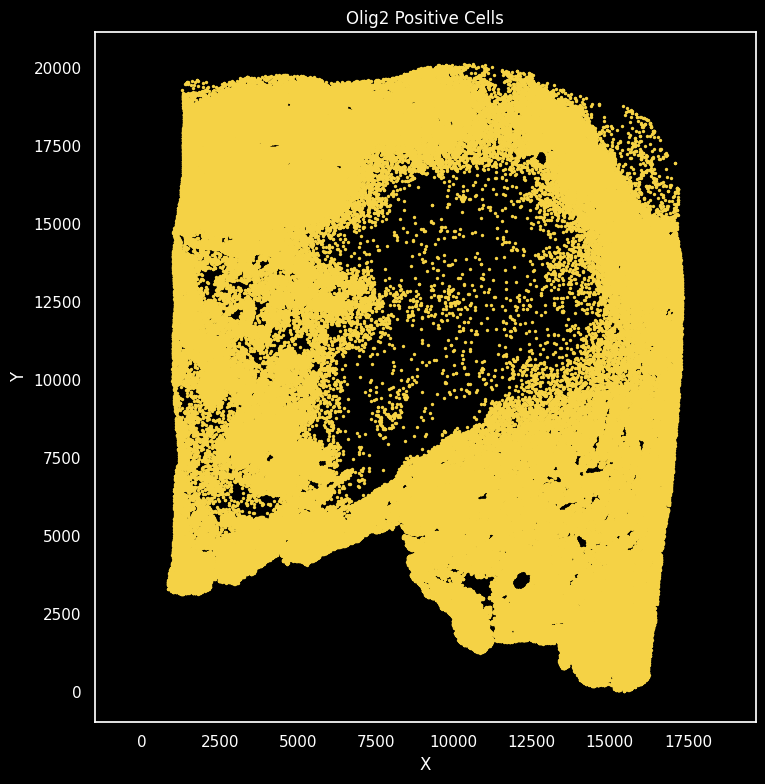

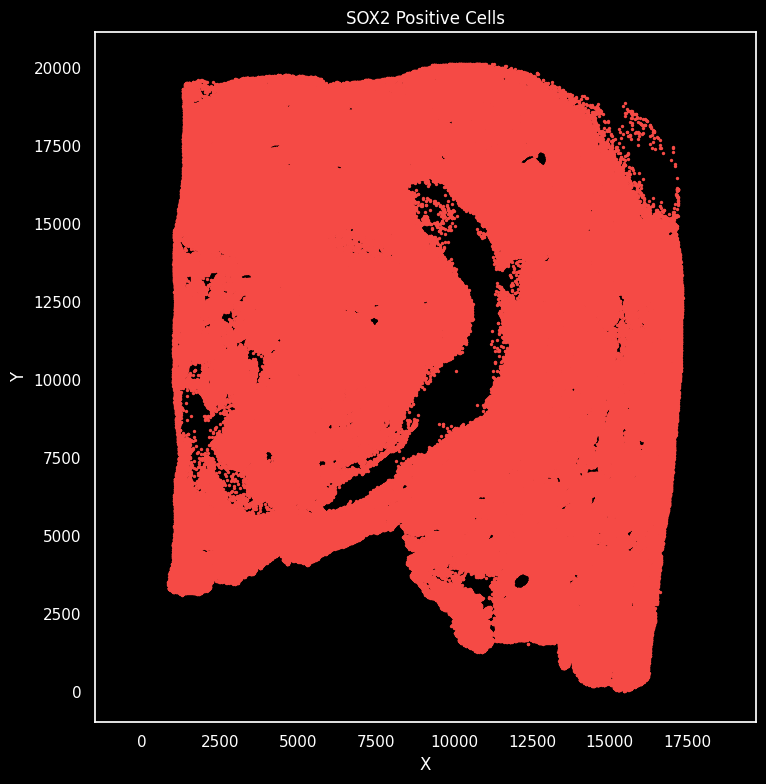

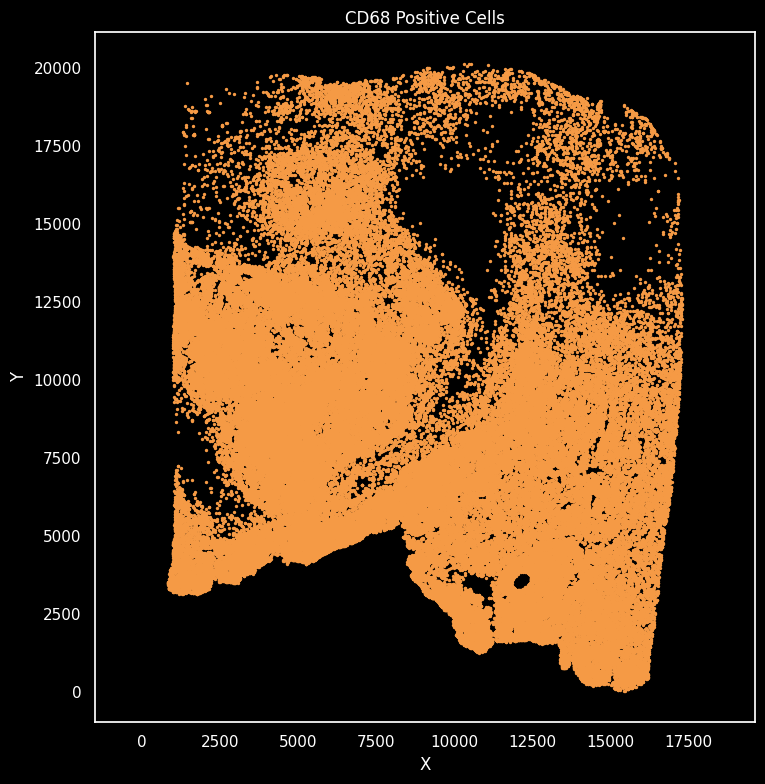

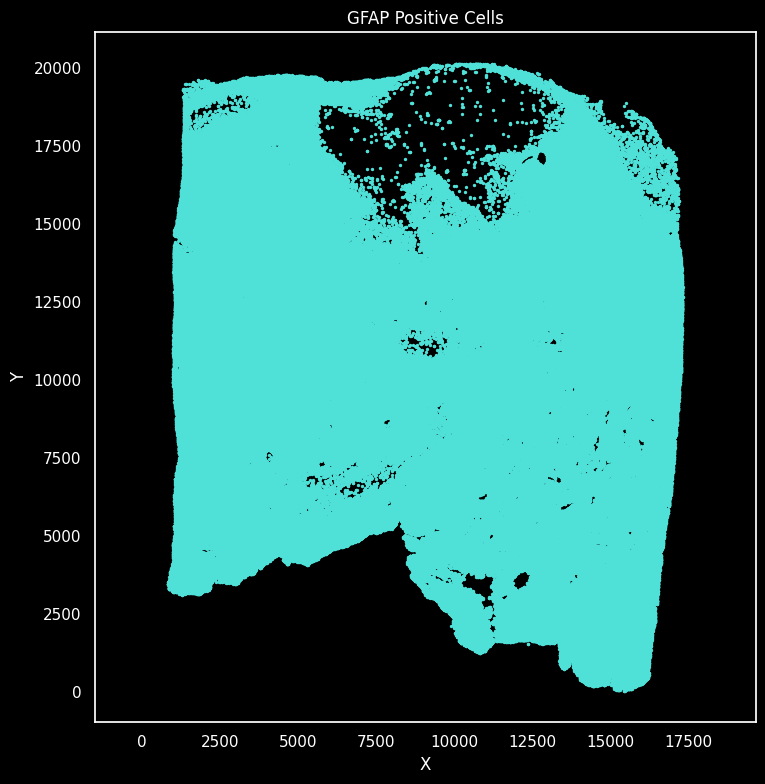

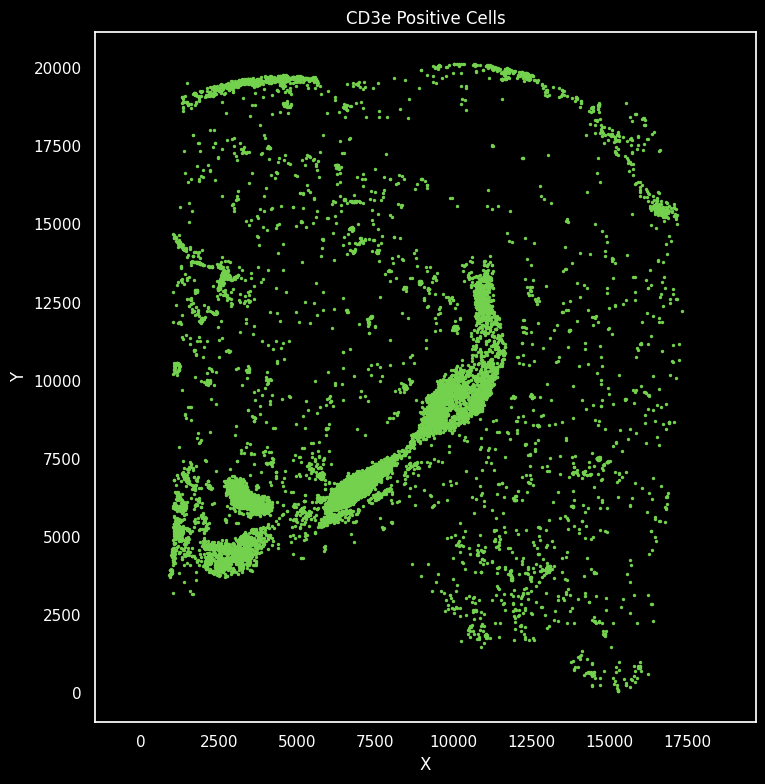

In [23]:
# Loop over all markers and plot solid-colour dots for positive cells.
for marker, colour in sc_data.uns['marker_colors'].items():

    if marker == 'DAPI_pos':
        continue  # skip DAPI

    # Filter for positive cells for this marker.
    marker_mask = sc_data.obs[marker]
    df = sc_data.obs[marker_mask].copy()

    plt.style.use('dark_background')
    plt.figure(figsize=(8, 8))
    plt.scatter(df['X_centroid'], df['Y_centroid'], color=colour, s=2)
    plt.title(f'{marker.replace("_pos", "")} Positive Cells')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.axis('equal')
    plt.tight_layout()
    # Optional: save figure
    #plt.savefig(path + 'GBM(stardist)/'+ f'{marker.replace("_pos", "")}_positive_cells(BLACK).png', dpi=300)
    plt.show()

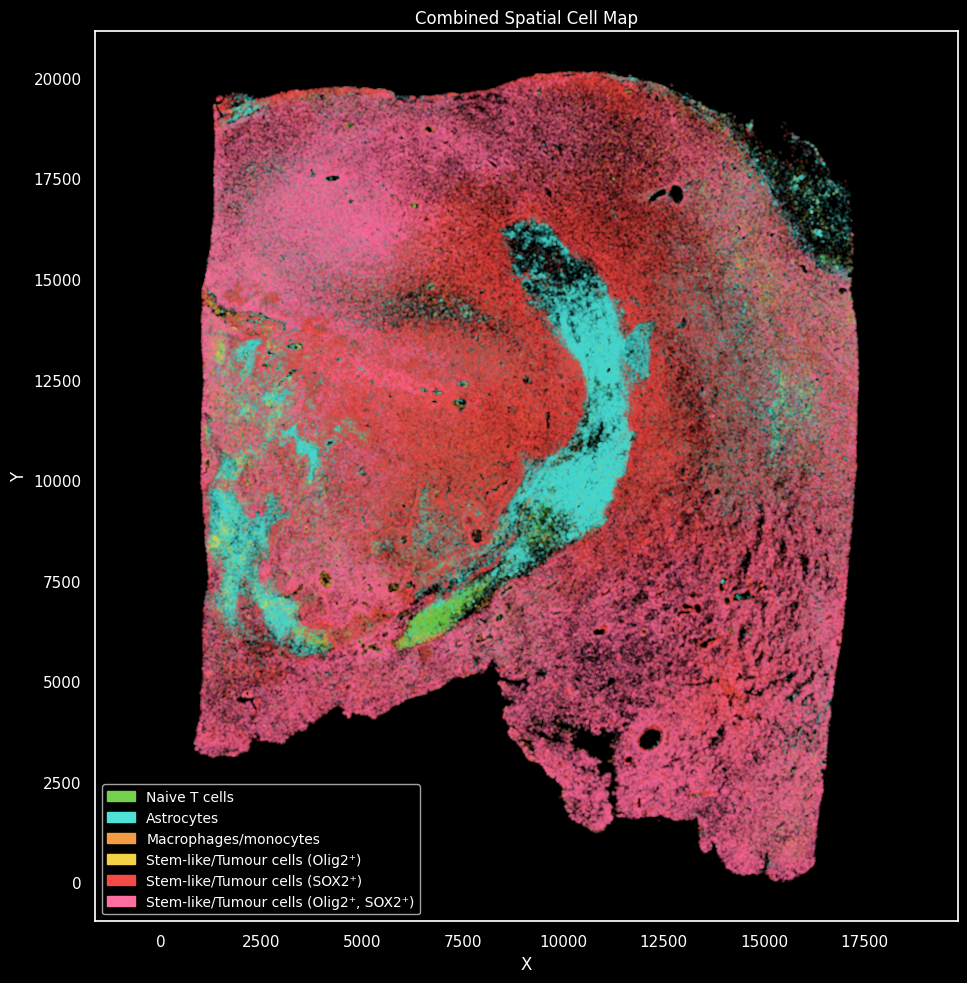

In [26]:
import matplotlib.patches as mpatches

# Define generic cell categories and their representative colours.
# This simplifies visual interpretation by grouping related cell types.
legend_dict = {
    'Naive T cells': '#73D14D',                           # Green
    'Astrocytes': '#4FE0D7',                              # Blue
    'Macrophages/monocytes': '#F59A45',                   # Orange
    'Stem-like/Tumour cells (Olig2⁺)': '#F5D245',         # Yellow
    'Stem-like/Tumour cells (SOX2⁺)': '#F54A45',          # Red
    'Stem-like/Tumour cells (Olig2⁺, SOX2⁺)': '#FF6EA1'   # Pink
}

# Manually define coloured boxes (patches) for the legend,
# so that each generic cell group is clearly labelled in the plot.
legend_patches = [mpatches.Patch(color=colour, label=label) for label, colour in legend_dict.items()]

plt.figure(figsize=(10, 10))

# Plot each cell category using uniform transparency (alpha).
for label, colour in legend_dict.items():
    if label == 'DAPI⁺ Unknown Cell':
        continue
    subset = sc_data.obs[sc_data.obs['cell type'] == label]
    plt.scatter(
        subset['X_centroid'],
        subset['Y_centroid'],
        color=colour,
        alpha=0.08,  # Uniform translucency for visual clarity
        s=2
    )

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Combined Spatial Cell Map')
plt.axis('equal')
plt.legend(handles=legend_patches, markerscale=5, loc='lower left', fontsize='small')
plt.tight_layout()
# Optional: save figure
#plt.savefig(path + 'GBM(stardist)/' + 'combined_map(gbm,stardist)(B).png', dpi=300)
plt.show()
# to change the background back to white:
plt.style.use('default')

In [24]:
# Summary statistics of biomarker intensity values (used to assess skewness and range).

filtered_clean[biomarkers].describe().round(3)

,Olig2,SOX2,CD68,GFAP,CD3e
count,964466.000,964466.000,964466.000,964466.000,964466.000
mean,10.331,36.609,10.713,71.713,11.358
std,10.816,32.857,13.441,26.115,8.789
min,0.603,0.722,0.859,12.191,0.760
25%,4.167,11.168,3.772,54.193,6.676
50%,6.868,25.598,5.921,68.060,8.968
75%,11.976,53.229,11.617,83.924,12.906
max,168.664,247.109,227.330,255.000,219.890


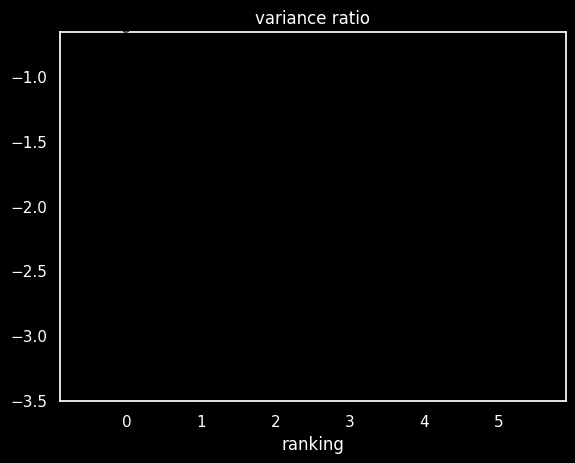

In [25]:
# Log1p transformation is applied to reduce right-skew and compress larger values.
# This helps normalise intensity distributions and improves comparability across markers.

sc_data.X = np.log1p(sc_data.X)

# With only few biomarkers (6 in my training set, 5 in GBM set), PCA isn’t strictly required for dimensionality reduction.
# However, Scanpy expects PCA before computing neighbours and t-SNE/UMAP because:
# It follows the standard pipeline, allows variance explained analysis, and ensures consistency in clustering and visualisation.

sc.tl.pca(sc_data, svd_solver='auto', n_comps=5)  # Use 'n_comps= [number of biomarkers]' to match the number of biomarkers (default is 50).

# Plot how much variance is explained by each principal component.
# General rule: plot 6–20 PCs, then identify the 'elbow' to choose PCs for downstream steps.
sc.pl.pca_variance_ratio(sc_data, n_pcs=5, log=True)  # log=True applies log scale to Y-axis.

# Compute the nearest-neighbour graph using PCA representation.
# Required for clustering (e.g. Leiden) and embedding (e.g. t-SNE, UMAP).
sc.pp.neighbors(sc_data, n_neighbors=20)

# Note: It's good practice to save intermediate .h5ad files after memory-intensive steps like pp.neighbors,
# to avoid recomputing them and reduce memory/time usage in future runs.
sc_data.write(path + 'after_neighbors.h5ad')
#sc_data = sc.read(path + 'after_neighbors.h5ad')  # Load saved neighbourhood graph.

In [27]:
# Leiden is an improved version of Louvain, offering more stable and well-connected clusters.
# It detects communities of phenotypically similar cells based on marker expression.
# The 'resolution' parameter controls the granularity of clustering (higher = more, smaller clusters).
# Tip: Try multiple resolutions to reach a biologically meaningful number of clusters based on domain knowledge and expectations.

res_list = [0.25, 0.3, 0.4, 0.45, 0.5]


for res in res_list:
    sc.tl.leiden(
        sc_data,
        flavor='igraph', # Using the igraph implementation and a fixed number of iterations can be significantly faster, especially for larger datasets.
        n_iterations=2, # n_iterations sets how many times the Leiden algorithm is run to refine cluster partitions.
                        # A small number (e.g. 2) is often sufficient, but increasing it can improve stability of results in some cases
        resolution=res,
        key_added=f'leiden_{res}'
    )
    sc_data.write(path + f'my_sc_data_after_leiden_{res}.h5ad')

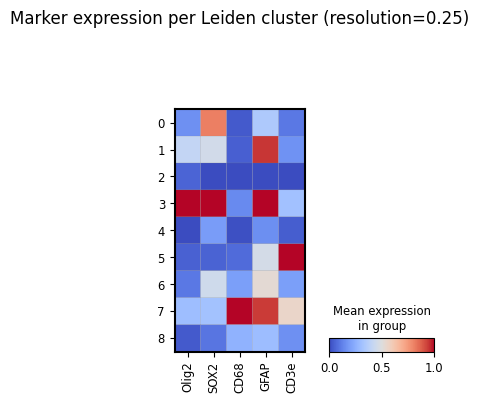

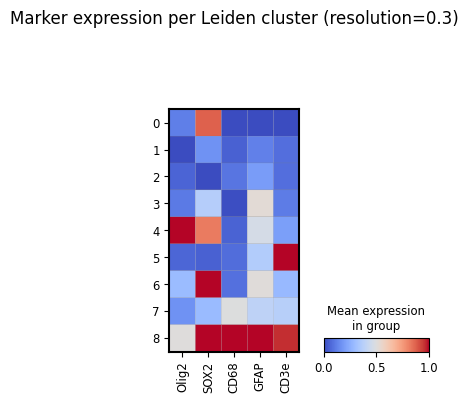

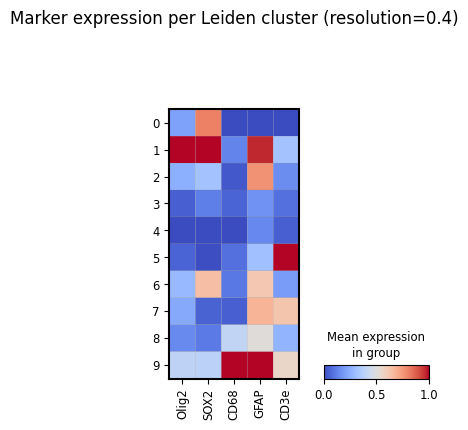

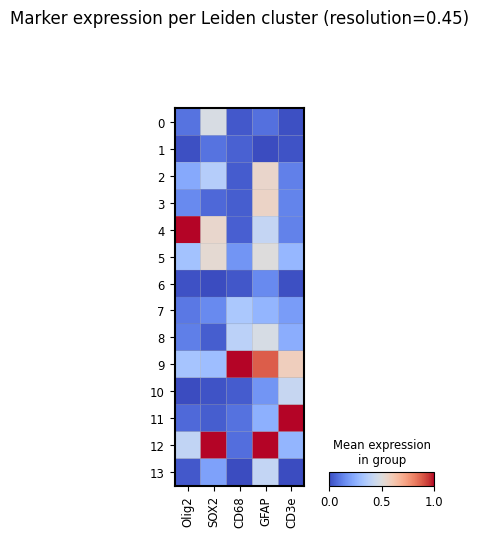

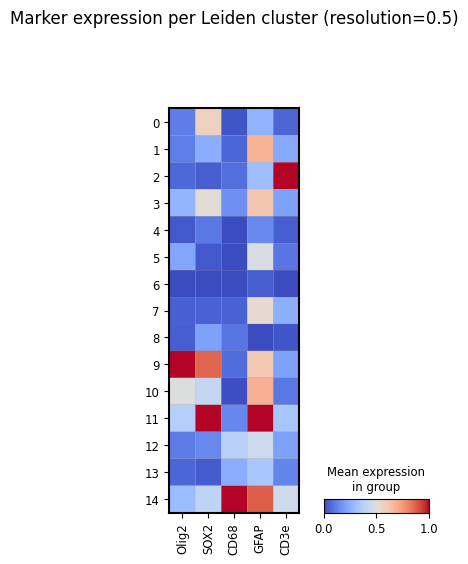

In [28]:
# Loop over clustering resolutions to visualise how marker expression differs across Leiden clusters.
# Matrix plots help compare expression patterns and assess biological relevance of clusters.

for res in res_list:
    sc.pl.matrixplot(
        sc_data,
        var_names=biomarkers,
        groupby=f'leiden_{res}',
        standard_scale='var',   # scales each marker between 0 and 1
        cmap='coolwarm',
        title=f'Marker expression per Leiden cluster (resolution={res})'
    )

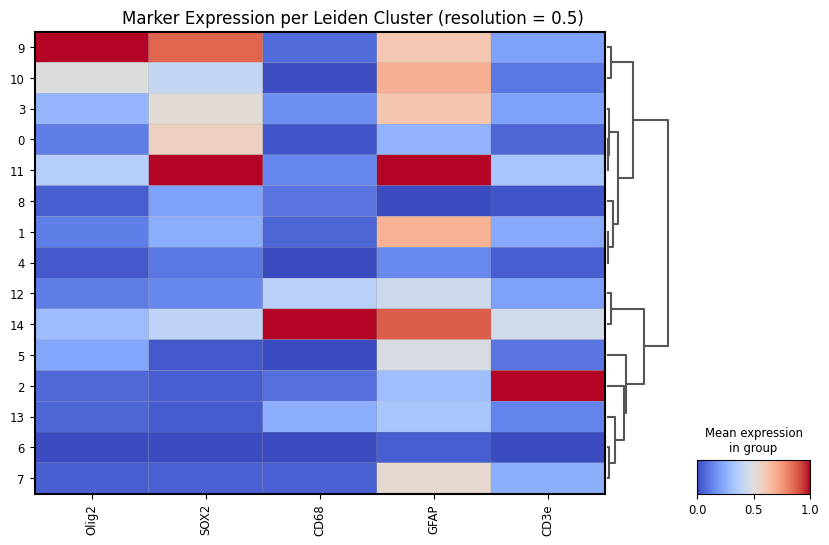

In [53]:
# Matrix plot showing marker expression per Leiden cluster.
# 'groupby='leiden_0.5'' selects the clustering resolution with the desired number of clusters.
# Each cluster should be manually annotated based on marker expression patterns and biological meaning,
# to then use it for cell phenotyping.

sc.settings.figdir = path # Save in custom directory 
sc.pl.matrixplot(
    sc_data,
    var_names= biomarkers,
    groupby='leiden_0.5',            # Choose the one resulting in the desired number of clusters.
    standard_scale='var',
    cmap='coolwarm',
    dendrogram=True,
    figsize=(10, 6),
    title='Marker Expression per Leiden Cluster (resolution = 0.5)',
    save= 'matrixplot_leiden_0.5(gbm,stardist).png'
)

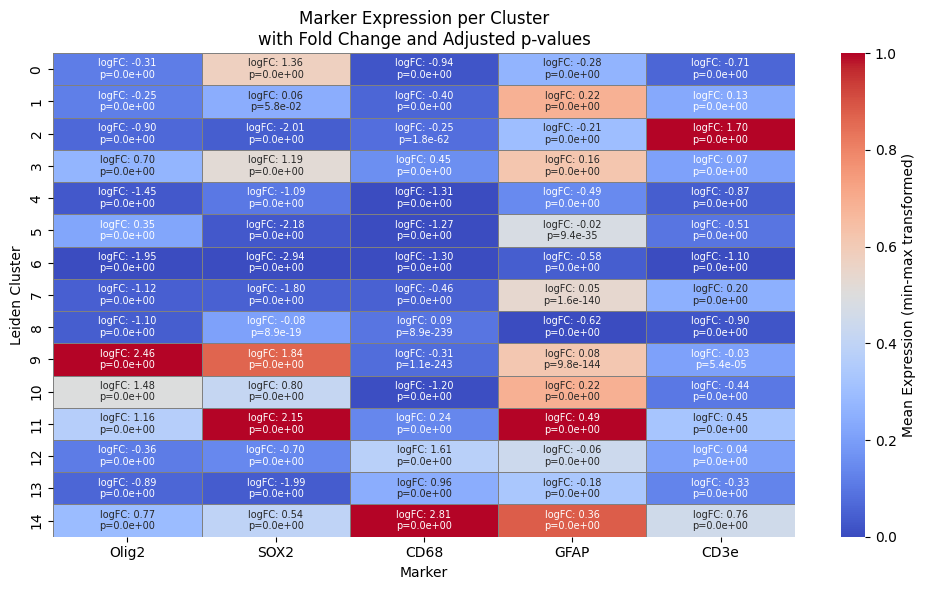

In [74]:
# This block creates a customised heatmap (matrix plot) showing
# log fold change (logFC) and adjusted p-value (p) within each heatmap cell
# These values are extracted from Scanpy's rank_genes_groups results for each Leiden cluster.
# Enable tie correction for Wilcoxon test to account for tied ranks,
# which are common in spatial proteomics due to zero or repeated intensities.

sc.tl.rank_genes_groups(sc_data, groupby='leiden_0.5', use_raw = False, method='wilcoxon', tie_correct = True)

# Define the cluster labels and marker names.
clusters = sc_data.obs['leiden_0.5'].cat.categories

# Create an empty annotation DataFrame (text annotations).
ann_df = pd.DataFrame(index=clusters, columns=biomarkers)

# Create a DataFrame with mean expression per cluster.
expressions = sc_data_plot.to_df().groupby(sc_data.obs['leiden_0.5'], observed=True).mean()[biomarkers]

# Min-max normalisation is applied per marker to scale values between 0 and 1.
# This is done for visualisation purposes only and does not affect the original data.
expr_norm = (expressions - expressions.min()) / (expressions.max() - expressions.min())

# Loop over each cluster and extract fold change and p-values for each marker.
for cluster in clusters:
    df = sc.get.rank_genes_groups_df(sc_data, group=cluster)

    for marker in biomarkers:
        row = df[df['names'] == marker]
        logfc = row['logfoldchanges'].values[0]
        p = row['pvals_adj'].values[0]
        #fc = 2 ** logfc                     # Convert logFC to fold change if preferred
        ann_df.loc[cluster, marker] = f'logFC: {logfc:.2f}\np={p:.1e}'

# Plot heatmap with expressions and annotations.
plt.figure(figsize=(10, 6))
sns.heatmap(expr_norm, 
            annot=ann_df, 
            fmt='', 
            cmap='coolwarm', 
            linewidths=0.5, 
            linecolor='gray', 
            annot_kws={'size': 7},
            cbar_kws={'label': 'Mean Expression (min-max transformed)'})
plt.title('Marker Expression per Cluster\nwith Fold Change and Adjusted p-values')
plt.ylabel('Leiden Cluster')
plt.xlabel('Marker')
plt.tight_layout()
# Optional: save figure
plt.savefig(path + 'matrixplot_fold_pval.png', dpi=300)
plt.show()

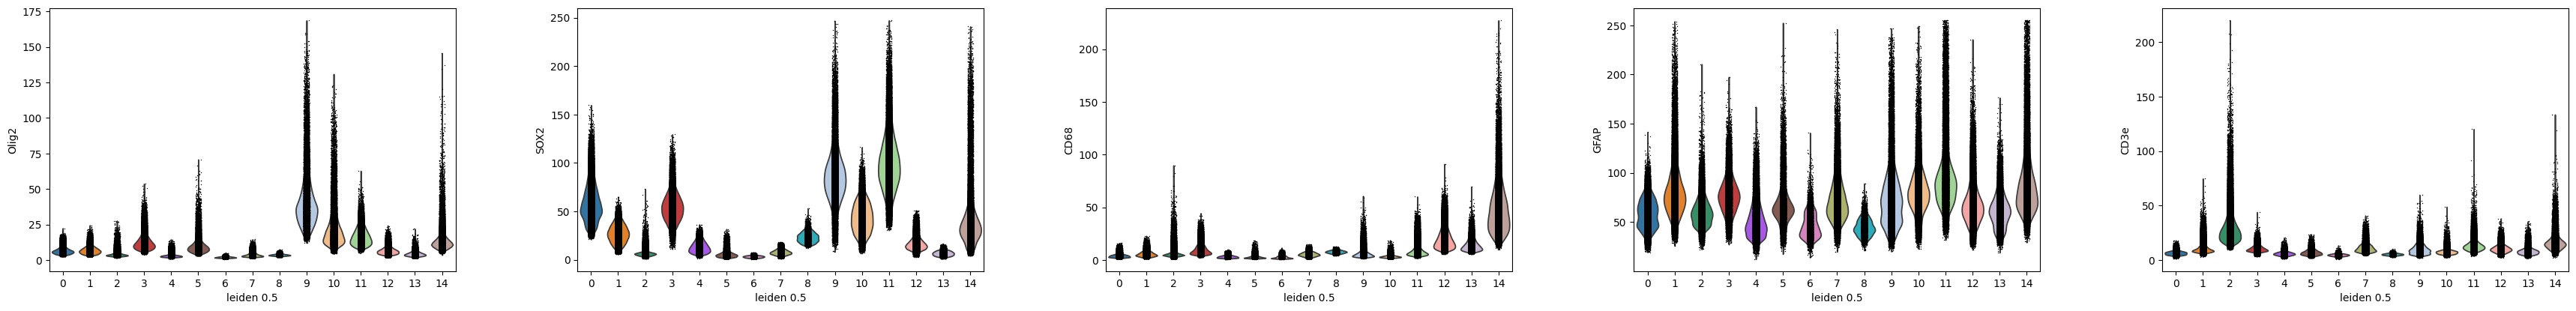

In [67]:
# Plot violin plots of marker expression across Leiden clusters.
# This visualises expression distributions (density and spread) for each marker within each cluster.

sc.pl.violin(sc_data, keys= biomarkers, groupby='leiden_0.5')

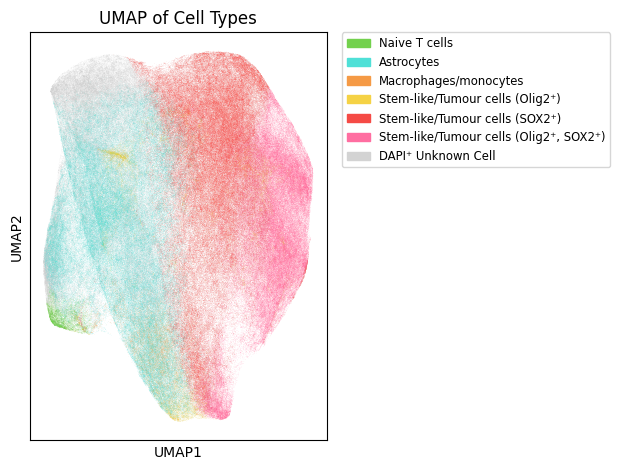

In [75]:
# Compute and plot UMAP.
# UMAP projects high-dimensional data (depending on the number of biomarkers used) into 2D for visualisation.
# It preserves the local structure, similar cells remain close, dissimilar ones are pushed apart.

# Define a legend as per assigned cell phenotypes.
legend_dic2 = {
    'Naive T cells': '#73D14D',                           # Green
    'Astrocytes': '#4FE0D7',                              # Blue
    'Macrophages/monocytes': '#F59A45',                   # Orange
    'Stem-like/Tumour cells (Olig2⁺)': '#F5D245',         # Yellow
    'Stem-like/Tumour cells (SOX2⁺)': '#F54A45',          # Red
    'Stem-like/Tumour cells (Olig2⁺, SOX2⁺)': '#FF6EA1',  # Pink
    'DAPI⁺ Unknown Cell': '#D3D3D3'                       # Light Gray
}

# Create manual legend handles.
legend_patches2 = [mpatches.Patch(color=colour, label=label) for label, colour in legend_dic2.items()]

# UMAP layout (optional: use specific parameters [min_dist, spresd] to control visual spread).
sc.tl.umap(sc_data, min_dist=0.05, spread=0.5)

# Save UMAP layout as .h5ad file (recommended for large datasets to save compute time for later).
sc_data.write(path + 'after_umap.h5ad')

# Plot UMAP coloured by cell type.
sc.pl.umap(
    sc_data,
    color='cell type',
    show=False, # Plot UMAP without displaying (for custom edits).
    legend_loc=None
)

# Add manual legend outside the plot.
plt.legend(
    handles=legend_patches2,
    bbox_to_anchor=(1.05, 1), # to locate the legend outside the plot (on the right)
    loc='upper left',
    frameon=True,
    fontsize='small',
    borderaxespad=0 # No space between legend and plot
)
plt.title('UMAP of Cell Types')
plt.tight_layout()
# plt.savefig(path + 'umap_custom_legend(gbm_log).png', dpi=300, bbox_inches='tight')
plt.show()

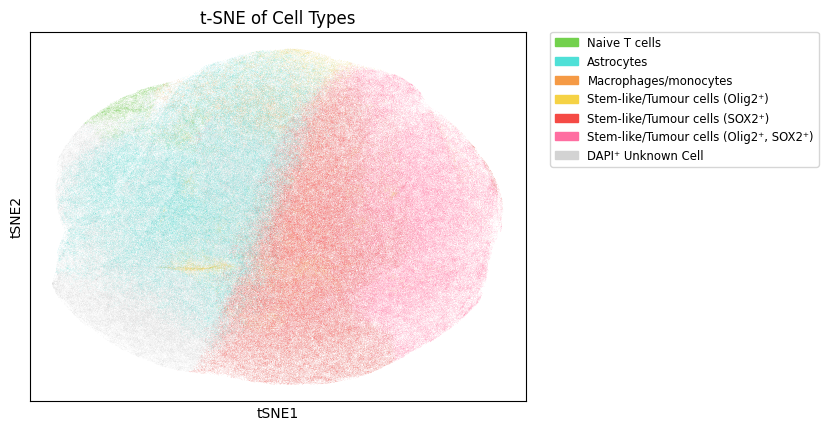

In [70]:
# Compute and plot t-SNE.
# t-SNE is a non-linear dimensionality reduction method that visualises similarities between cells in 2D.
# The 'perplexity' parameter roughly reflects the number of nearest neighbours used.
# 'early_exaggeration' controls how tightly clusters are packed and how much space is placed between them in 2D.
# 'learning_rate'controls optimisation step size

# Recommended: Use precomputed t-SNE to avoid re-running (which is memory- and time-intensive).
sc.tl.tsne(sc_data, perplexity=30, early_exaggeration=12, learning_rate=200)
sc_data.write(path + 'after_tsne_log.h5ad')

# Plot without the default legend.
sc.pl.tsne(sc_data,
           color='cell type',
           show=False,
           legend_loc=None
           )

# Add custom legend outside the plot.
plt.legend(
    handles=legend_patches2,
    bbox_to_anchor=(1.05, 1),
    loc='best',
    frameon=True,
    fontsize='small',
    borderaxespad=0
)
plt.title("t-SNE of Cell Types")
plt.savefig(path + 'tsne_gbm_log(stardist).png', dpi=300, bbox_inches='tight')
plt.show()

## Scimap

In [14]:
# Prepare a copy of sc_data for SciMap analysis.
# Flip the X coordinate (mirror across vertical axis) to match the orientation of the original image.
# This adjustment is needed because SciMap expects image-style coordinate layout for plotting.

sm_data = sc_data.copy()
sm_data.obs['Y_centroid'] = sm_data.obs['Y_centroid'].max() - sm_data.obs['Y_centroid']
sm_data.obs.head()

,X_centroid,Y_centroid,cell type,Olig2_pos,SOX2_pos,CD68_pos,GFAP_pos,CD3e_pos,leiden_0.25,leiden_0.3,leiden_0.4,leiden_0.45,leiden_0.5
cell_0,9889.0,48.06,Stem-like/Tumour cells (SOX2⁺),False,True,False,False,False,0,0,0,0,0
cell_1,9880.9,50.54,Stem-like/Tumour cells (SOX2⁺),False,True,False,False,False,4,0,0,0,0
cell_2,9849.1,50.28,Stem-like/Tumour cells (SOX2⁺),False,True,False,False,False,0,0,0,0,0
cell_3,9866.3,52.08,DAPI⁺ Unknown Cell,False,False,False,False,False,4,0,1,2,0
cell_4,9886.0,57.86,Stem-like/Tumour cells (SOX2⁺),False,True,False,False,False,8,7,13,14,10


In [15]:
# Assign a dummy 'imageid' since all cells originate from the same image.
# This is required by scimap's spatial analysis functions.
sm_data.obs['imageid'] = 'test_tissue1'

# Compute spatial distances between cell types using the 'cell type'(custom) annotation.
sm_data = sm.tl.spatial_distance(sm_data, phenotype='cell type')

Processing Image: test_tissue1


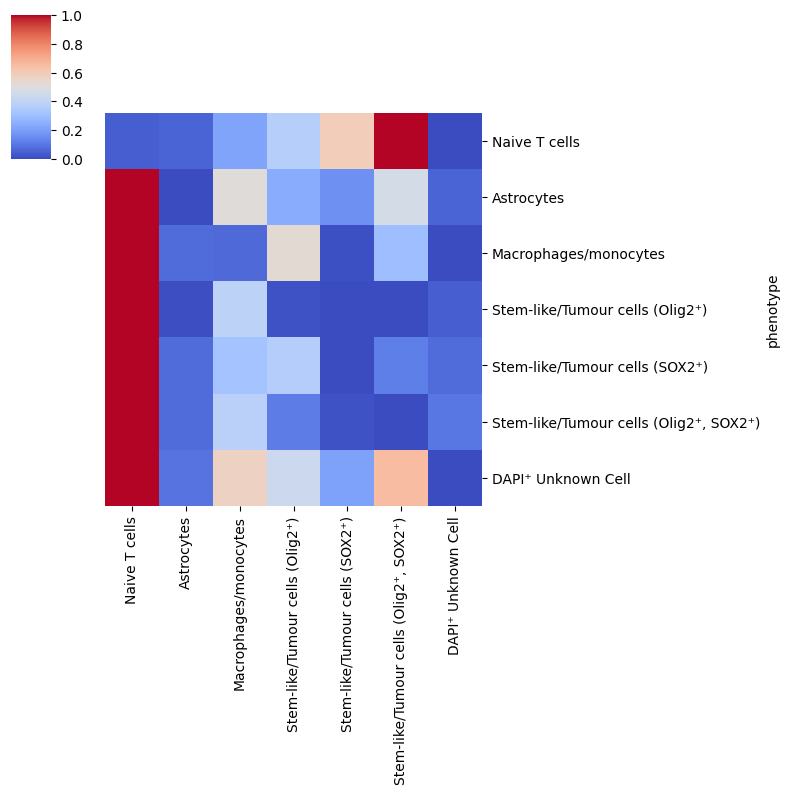

In [16]:
# Plot spatial distance heatmap between cell types.
# Set return_data=True to capture the underlying data for further custom visualisation.

df = sm.pl.spatial_distance (
    sm_data,
    phenotype= 'cell type',
    figsize=(8,8),
    heatmap_cmap = 'coolwarm',
    return_data = True
    )

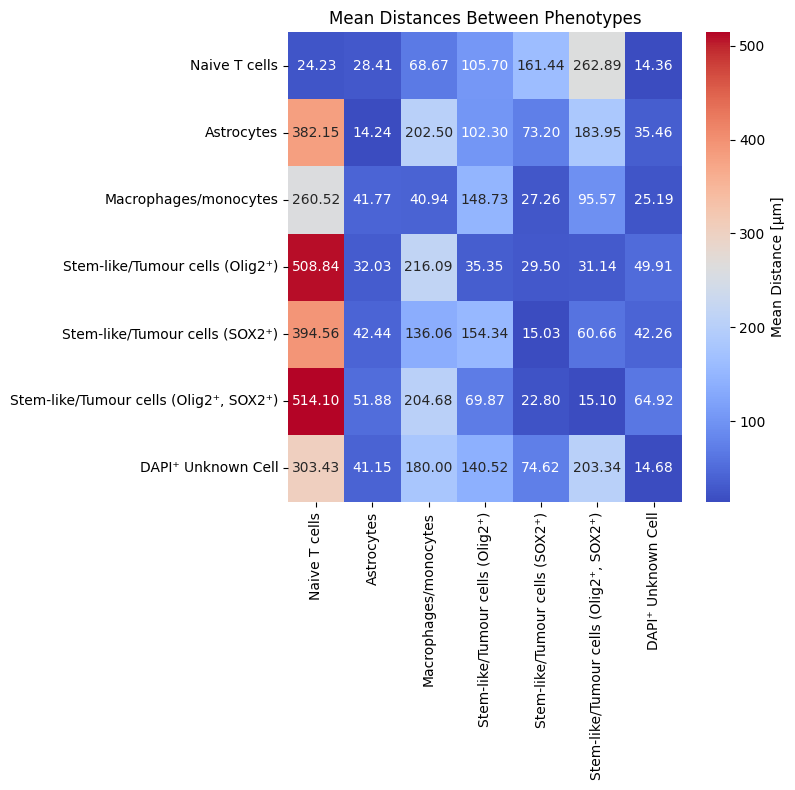

In [17]:
# Create a custom heatmap showing pairwise mean spatial distances between phenotypes.

plt.figure(figsize=(8, 8))
ax = sns.heatmap(
    df,
    annot=True,                     # Show numeric values in each cell
    fmt='.2f',
    cmap='coolwarm',
    cbar_kws={'label': 'Mean Distance [µm]'}
)

# Remove default axis labels (phenotype names are already shown on the heatmap itself).
ax.set_ylabel('')
ax.set_xlabel('')

plt.title('Mean Distances Between Phenotypes')
plt.tight_layout()
# Optional: save figure
# plt.savefig(path + 'phenotype_distances_heatmap.png', dpi=300)
plt.show()

# Note: If some distances dominate due to skewed values,
# applying a log transform can improve visual interpretation:
# df_log = np.log1p(df)


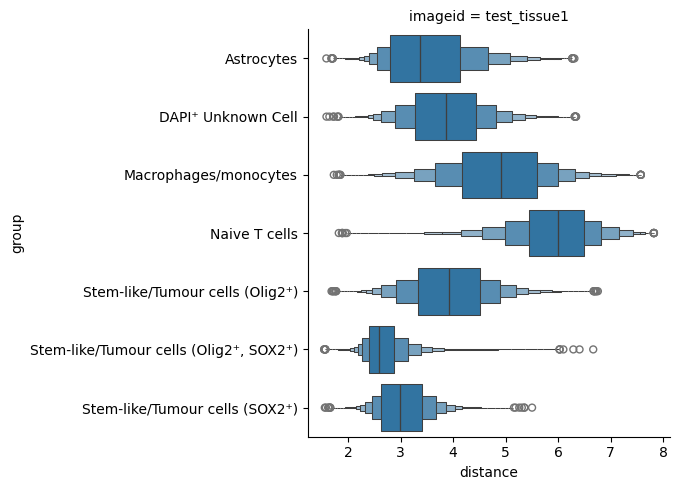

In [19]:
# Plot shortest mean distances from tumour cells to other phenotypes ('distance_from' can be changed as per need).
# log1p transformation (log(x + 1)) is applied to reduce skew from large outliers
# and improve interpretability of numeric distance differences.

sm.pl.spatial_distance(
    sm_data,
    phenotype='cell type',
    log=True,
    method='numeric',
    distance_from='Stem-like/Tumour cells (Olig2⁺, SOX2⁺)',
    height=5,
    aspect=11/8  # Controls width-to-height ratio of the plot
    # fileName = 'distance_from_tumour.png',
    # saveDir = path
)


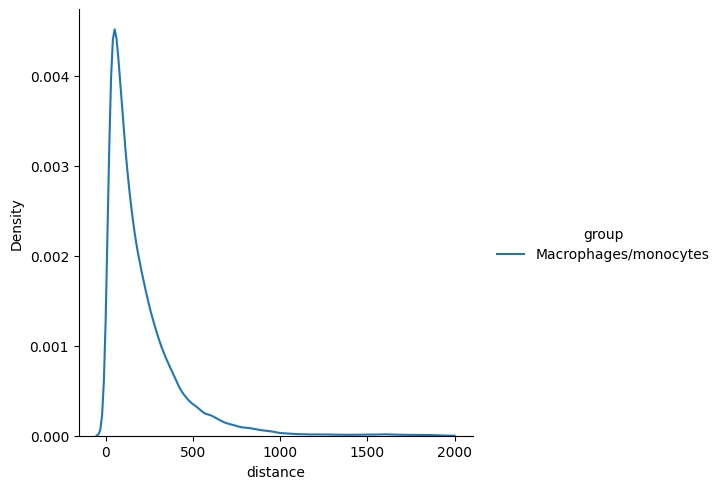

In [21]:
# Plot distribution of distances between specific (custom) cell types.
# This shows how far cells of one phenotype tend to be from another.

sm.pl.spatial_distance(
    sm_data,
    method='distribution',
    distance_from='Stem-like/Tumour cells (Olig2⁺, SOX2⁺)',
    distance_to='Macrophages/monocytes',
    phenotype='cell type',
    plot_type='kde',
    x_axis='distance',
    y_axis='group'
    )

In [22]:
# Compute spatial neighbourhood counts using KNN.
# For each cell, this calculates how many neighbouring cells (within k) belong to each phenotype.
# The result is stored in .obs['spatial_count'] as a dictionary for each cell.

sm_data = sm.tl.spatial_count(sm_data, phenotype='cell type', method='knn', label='spatial_count')

Identifying the 10 nearest neighbours for every cell


In [23]:
# Cluster cells based on their spatial neighbourhood composition using the K-means algorithm.
# This groups cells into custom number of clustersbased on similarities in their local neighbourhood profiles,
# previously calculated in 'spatial_count'.
# K-means clustering is performed on these vectors using Euclidean distance.
# The resulting cluster labels are stored in .obs['neigh_kmeans'].

sm_data = sm.tl.spatial_cluster(
    sm_data,
    df_name='spatial_count',     # Neighbourhood profile to cluster on
    method='kmeans',             # Clustering algorithm
    k=6,                         # Number of clusters to identify
    label='neigh_kmeans'         # Name for the output column
)


Kmeans clustering


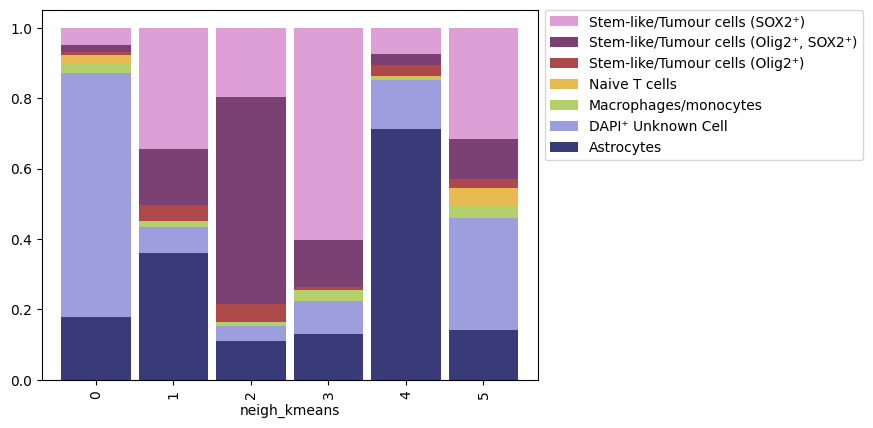

In [30]:
# Plot a stacked bar chart showing the composition of each spatial neighbourhood cluster
# in terms of assigned cell types.
# Helps interpret which phenotypes are enriched within each spatial context cluster.

composition_df = sm.pl.stacked_barplot(
    sm_data,
    x_axis='neigh_kmeans',
    y_axis='cell type',
    matplotlib_cmap='tab20b',
    return_data = True
)

# Extract cell type composition per spatial cluster as a DataFrame,
# where each row represents a spatial cluster, and each column shows
# the proportion of a given cell type within that cluster.

composition_df.head()

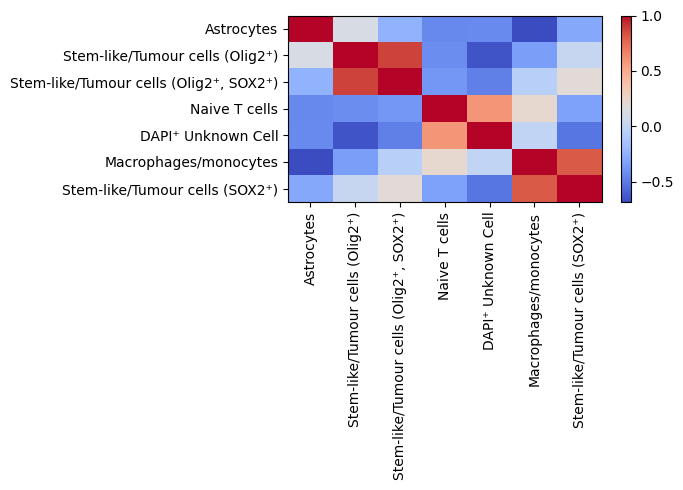

In [25]:
# Plot correlation of cell type proportions across spatial clusters (neigh_kmeans).
# This reveals which cell types tend to co-occur or are mutually exclusive across neighbourhoods.

sm.pl.groupCorrelation(
    sm_data,
    groupBy='cell type',
    condition='neigh_kmeans',
    figsize=(7, 5),
    cmap='coolwarm'
    # fileName='groupCorrelation.png', saveDir=path
)

In [26]:
# Rename numerical spatial cluster labels  into more interpretable CN labels.
# This helps standardise cluster naming for downstream analysis and visualisation.

rename_dict = {
    'CN1': ['0'],
    'CN2': ['1'],
    'CN3': ['2'],
    'CN4': ['3'],
    'CN5': ['4'],
    'CN6': ['5']
}

# Rename the neighbourhood cluster labels from numeric (e.g., 0, 1, ...) to CN1–CN6 for clarity and consistency.
# This creates a new column 'CNs' in `.obs` reflecting the renamed clusters.

sm_data = sm.hl.rename(sm_data, rename=rename_dict, from_column='neigh_kmeans', to_column='CNs')

Renaming 0 to CN1
Renaming 1 to CN2
Renaming 2 to CN3
Renaming 3 to CN4
Renaming 4 to CN5
Renaming 5 to CN6


In [31]:
# Note: scimap’s spatial_scatterPlot may distort spatial proportions (e.g., squished aspect ratio),
# particularly for wide tissue sections. At this point, the AnnData object can be saved as .h5ad
# and reloaded in a Squidpy-compatible environment for spatial plotting with preserved geometry.

sm_data.write(path + 'GBM(stardist)/' + 'after_scimap.h5ad')